##### 改ざん画像データセットのダウンロード・解凍
- 前回の試行の続きを行いたい場合（再開モードの場合）は実行不要です．
- これは本来のDEFACTOではなく，物体削除系の改ざん画像のみを取り出した簡易版です．
- 改ざん領域を含む128x128ピクセルの部分を切り出して使用しています（元々の改ざん領域のサイズが128x128より大きいものは無視しました）．
- ファイルサイズが大きいので，必要になるまでダウンロードしないほうが良いです．
- 数十分～1時間程度かかる可能性があります．

In [30]:
import os
import torch
from torchvision import transforms
from mylib.data_io import CSVBasedDataset

##### データセットの場所やバッチサイズなどの定数値の設定

In [31]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
import torch

RESTART_MODE = False

DEVICE = 'cuda:0'

USE_AMP = True
FLOAT_DTYPE = torch.float16 


if DEVICE == 'cpu':
    USE_AMP = False 
LOSS_SCALER = torch.amp.grad_scaler.GradScaler(enabled=USE_AMP, device='cuda', init_scale=2**16)
ADAM_EPS = 1e-4 if USE_AMP and (FLOAT_DTYPE == torch.float16) else 1e-8

N_EPOCHS = 3

BATCH_SIZE = 100

# データセットの存在するフォルダ・ファイル名
DATA_DIR = './Datasets/'
TRAIN_INPUT_IMAGES_FILE  = 'defacto_train_input_images.pt'
TRAIN_TARGET_IMAGES_FILE = 'defacto_train_target_images.pt'
VALID_INPUT_IMAGES_FILE  = 'defacto_valid_input_images.pt'
VALID_TARGET_IMAGES_FILE = 'defacto_valid_target_images.pt'
TEST_INPUT_IMAGES_FILE   = 'defacto_test_input_images.pt'
TEST_TARGET_IMAGES_FILE  = 'defacto_test_target_images.pt'

# 画像サイズ
H = 128 # 縦幅
W = 128 # 横幅
C = 3 # 入力画像のチャンネル数（カラー画像なら3，グレースケール画像なら1．なお，正解のマスク画像のチャンネル数は常に1）

# 学習結果の保存先フォルダ
MODEL_DIR = './defacto_models/'

# 学習結果のニューラルネットワークの保存先
MODEL_FILE = os.path.join(MODEL_DIR, 'forgery_detector_model.pth')

# 中断／再開の際に用いる一時ファイル
CHECKPOINT_EPOCH = os.path.join('./temp/', 'checkpoint_epoch.pkl')
CHECKPOINT_MODEL = os.path.join('./temp/', 'checkpoint_model.pth')
CHECKPOINT_OPT = os.path.join('./temp/', 'checkpoint_opt.pth')

##### ニューラルネットワークモデルの定義

In [32]:
from model import ForgeryDetector

##### 訓練データセットの読み込み

In [26]:
import torch
from torch.utils.data import DataLoader, random_split
from mylib.data_io import TensorDataset


# 再開モードの場合は，前回使用したデータセットをロードして使用する
if RESTART_MODE:

    # テンソルファイルを読み込み，前回使用したデータセットを用意
    train_dataset = TensorDataset(filenames=[
        os.path.join('./temp/', TRAIN_INPUT_IMAGES_FILE),
        os.path.join('./temp/', TRAIN_TARGET_IMAGES_FILE)
    ])
    valid_dataset = TensorDataset(filenames=[
        os.path.join('./temp/', VALID_INPUT_IMAGES_FILE),
        os.path.join('./temp/', VALID_TARGET_IMAGES_FILE)
    ])
    train_size = len(train_dataset)
    valid_size = len(valid_dataset)

# そうでない場合は，データセットを読み込む
else:

    # テンソルファイルを読み込み, 訓練データセットを用意
    dataset = TensorDataset(filenames=[
        os.path.join(DATA_DIR, TRAIN_INPUT_IMAGES_FILE),
        os.path.join(DATA_DIR, TRAIN_TARGET_IMAGES_FILE)
    ])

    # 訓練データセットを分割し，一方を検証用に回す
    dataset_size = len(dataset)
    valid_size = int(0.01 * dataset_size) # 全体の 1% を検証用に
    train_size = dataset_size - valid_size # 残りの 99% を学習用に
    train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

    # データセット情報をファイルに保存
    torch.save(torch.cat([torch.unsqueeze(train_dataset[i][0], dim=0) for i in range(len(train_dataset))], dim=0), os.path.join('./temp/', TRAIN_INPUT_IMAGES_FILE))
    torch.save(torch.cat([torch.unsqueeze(train_dataset[i][1], dim=0) for i in range(len(train_dataset))], dim=0), os.path.join('./temp/', TRAIN_TARGET_IMAGES_FILE))
    torch.save(torch.cat([torch.unsqueeze(valid_dataset[i][0], dim=0) for i in range(len(valid_dataset))], dim=0), os.path.join('./temp/', VALID_INPUT_IMAGES_FILE))
    torch.save(torch.cat([torch.unsqueeze(valid_dataset[i][1], dim=0) for i in range(len(valid_dataset))], dim=0), os.path.join('./temp/', VALID_TARGET_IMAGES_FILE))


# 訓練データおよび検証用データをミニバッチに分けて使用するための「データローダ」を用意
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)

In [33]:
from dataset import prepare_datasets, create_dataloaders

train_dataset, valid_dataset, train_size, valid_size = prepare_datasets(
    restart_mode=RESTART_MODE,
    data_dir=DATA_DIR,
    train_input_file=TRAIN_INPUT_IMAGES_FILE,
    train_target_file=TRAIN_TARGET_IMAGES_FILE,
    valid_input_file=VALID_INPUT_IMAGES_FILE,
    valid_target_file=VALID_TARGET_IMAGES_FILE
)

train_dataloader, valid_dataloader = create_dataloaders(
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    batch_size=BATCH_SIZE
)

##### 性能評価のための関数の定義

In [34]:
import torch


# 二枚の白黒画像の一致度を調べる
def region_consistency_metric(estimated, gt, threshold=0.2):

    def ratio(a, b):
        indices = b.nonzero()
        if len(indices) == 0:
            return 0
        else:
            return float(torch.mean(a[indices] / b[indices]))

    one = torch.ones(gt.size()).to(gt.device)
    zero = torch.zeros(gt.size()).to(gt.device)
    gt = torch.where(gt > threshold, one, zero)
    estimated = torch.where(estimated > threshold, one, zero)
    intersection = estimated * gt
    union = estimated + gt
    union = torch.where(union > 1, one, union)
    E = torch.sum(estimated, dim=(1, 2, 3))
    G = torch.sum(gt, dim=(1, 2, 3))
    I = torch.sum(intersection, dim=(1, 2, 3))
    U = torch.sum(union, dim=(1, 2, 3))
    recall = ratio(I, G)
    precision = ratio(I, E)
    iou = ratio(I, U)

    return recall, precision, iou

##### 学習処理の実行

Epoch 1:


  0%|          | 0/198 [00:00<?, ?it/s]

100%|██████████| 198/198 [00:19<00:00, 10.14it/s]


train loss = 0.270714


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]

valid loss = 0.261663
recall = 0.314973
precision = 0.272540
IoU = 0.119913



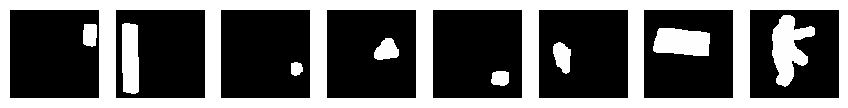

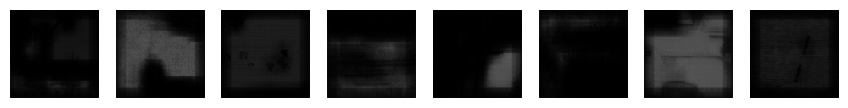

Epoch 2:


100%|██████████| 198/198 [00:19<00:00, 10.17it/s]


train loss = 0.255353


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]

valid loss = 0.260974
recall = 0.365043
precision = 0.254520
IoU = 0.131346



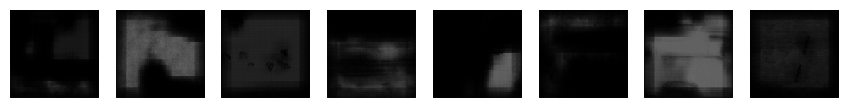

Epoch 3:


100%|██████████| 198/198 [00:19<00:00, 10.15it/s]


train loss = 0.252730


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]

valid loss = 0.260866
recall = 0.372812
precision = 0.274912
IoU = 0.136627



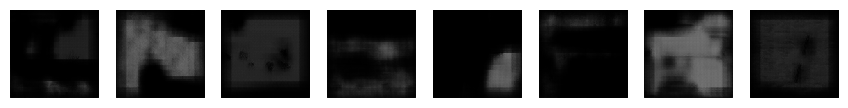

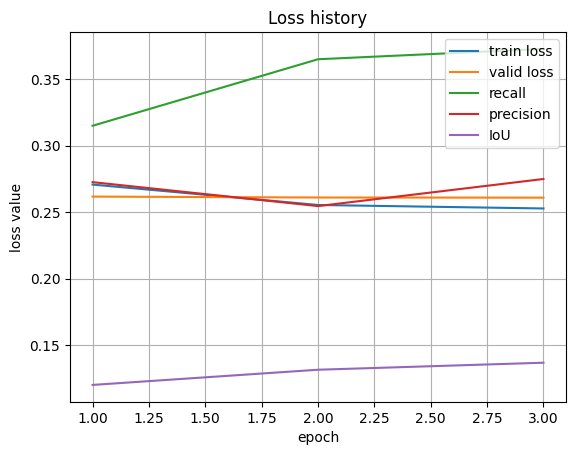

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from mylib.visualizers import LossVisualizer
from mylib.data_io import show_images
from mylib.utility import save_checkpoint, load_checkpoint

# エポック番号
INIT_EPOCH = 0 # 初期値
LAST_EPOCH = INIT_EPOCH + N_EPOCHS # 最終値

# ニューラルネットワークの作成
model = ForgeryDetector(C=C, H=H, W=W).to(DEVICE)

# 最適化アルゴリズムの指定（ここでは SGD でなく Adam を使用）
optimizer = optim.Adam(model.parameters(), eps=ADAM_EPS)

# 再開モードの場合は，前回チェックポイントから情報をロードして学習再開
if RESTART_MODE:
    INIT_EPOCH, LAST_EPOCH, model, optimizer = load_checkpoint(CHECKPOINT_EPOCH, CHECKPOINT_MODEL, CHECKPOINT_OPT, N_EPOCHS, model, optimizer)
    print('')

# 損失関数
loss_func = nn.BCELoss()

# 損失関数値を記録する準備
loss_viz = LossVisualizer(['train loss', 'valid loss', 'recall', 'precision', 'IoU'], init_epoch=INIT_EPOCH)

# 勾配降下法による繰り返し学習
for epoch in range(INIT_EPOCH, LAST_EPOCH):

    print('Epoch {0}:'.format(epoch + 1))

    # 学習
    model.train()
    sum_loss = 0
    for X, Y in tqdm(train_dataloader):
        for param in model.parameters():
            param.grad = None
        X = X.to(DEVICE) # 入力画像
        Y = Y.to(DEVICE) # 正解のマスク画像
        with torch.amp.autocast_mode.autocast(enabled=USE_AMP, device_type='cuda', dtype=FLOAT_DTYPE):
            Y_pred = model(X) # 入力画像 X をニューラルネットワークに入力し，改ざん領域の推測値 Y_pred を得る
        loss = loss_func(Y_pred.to(torch.float32), Y) # 損失関数の現在値を計算
        with torch.amp.autocast_mode.autocast(enabled=USE_AMP, device_type='cuda', dtype=FLOAT_DTYPE):
            LOSS_SCALER.scale(loss).backward() # 誤差逆伝播法により，個々のパラメータに関する損失関数の勾配（偏微分）を計算
            LOSS_SCALER.step(optimizer)
            LOSS_SCALER.update() # 勾配に沿ってパラメータの値を更新
            sum_loss += float(loss) * len(X)
    avg_loss = sum_loss / train_size
    loss_viz.add_value('train loss', avg_loss) # 訓練データに対する損失関数の値を記録
    print('train loss = {0:.6f}'.format(avg_loss))

    # 検証
    model.eval()
    sum_loss = 0
    sum_recall = 0
    sum_precision = 0
    sum_IoU = 0
    with torch.inference_mode():
        for X, Y in tqdm(valid_dataloader):
            X = X.to(DEVICE) # 入力画像
            Y = Y.to(DEVICE) # 正解のマスク画像
            Y_pred = model(X)
            loss = loss_func(Y_pred, Y)
            recall, precision, IoU = region_consistency_metric(Y_pred, Y) # 評価指標の値を計算
            sum_recall += recall * len(X)
            sum_precision += precision * len(X)
            sum_IoU += IoU * len(X)
            sum_loss += float(loss) * len(X)
    avg_recall = sum_recall / valid_size
    avg_precision = sum_precision / valid_size
    avg_IoU = sum_IoU / valid_size
    avg_loss = sum_loss / valid_size
    loss_viz.add_value('valid loss', avg_loss) # 検証用データに対する損失関数の値を記録
    loss_viz.add_value('recall', avg_recall) # 検証用データに対する評価指標の値を記録
    loss_viz.add_value('precision', avg_precision) # 同上
    loss_viz.add_value('IoU', avg_IoU) # 同上
    print('valid loss = {0:.6f}'.format(avg_loss))
    print('recall = {0:.6f}'.format(avg_recall))
    print('precision = {0:.6f}'.format(avg_precision))
    print('IoU = {0:.6f}'.format(avg_IoU))
    print('')

    # 学習経過の表示
    if epoch == 0:
        show_images(Y.to('cpu').detach(), num=8, num_per_row=8, title='ground truth', save_fig=False, save_dir=MODEL_DIR)
    show_images(Y_pred.to('cpu').detach(), num=8, num_per_row=8, title='epoch {0}'.format(epoch + 1), save_fig=False, save_dir=MODEL_DIR)

    # 現在の学習状態を一時ファイルに保存
    save_checkpoint(CHECKPOINT_EPOCH, CHECKPOINT_MODEL, CHECKPOINT_OPT, epoch+1, model, optimizer)

# 学習結果のニューラルネットワークモデルをファイルに保存
model = model.to('cpu')
torch.save(model.state_dict(), MODEL_FILE)

# 損失関数の記録をファイルに保存
loss_viz.save(v_file=os.path.join(MODEL_DIR, 'loss_graph.png'), h_file=os.path.join(MODEL_DIR, 'loss_history.csv'))

##### 学習済みニューラルネットワークモデルのロード

In [29]:
import torch


# ニューラルネットワークモデルとその学習済みパラメータをファイルからロード
model = ForgeryDetector(C=C, H=H, W=W)
model.load_state_dict(torch.load(MODEL_FILE, weights_only=True))

<All keys matched successfully>

##### テストデータセットの読み込み

In [9]:
from torch.utils.data import DataLoader
from mylib.data_io import TensorDataset


# テンソルファイルを読み込み, 訓練データセットを用意
if RESTART_MODE:
    test_dataset = TensorDataset(filenames=[
        os.path.join('./temp/', TEST_INPUT_IMAGES_FILE),
        os.path.join('./temp/', TEST_TARGET_IMAGES_FILE)
    ])
else:
    test_dataset = TensorDataset(filenames=[
        os.path.join(DATA_DIR, TEST_INPUT_IMAGES_FILE),
        os.path.join(DATA_DIR, TEST_TARGET_IMAGES_FILE)
    ])
test_size = len(test_dataset)

# テストデータをミニバッチに分けて使用するための「データローダ」を用意
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

##### テスト処理

100%|██████████| 10/10 [00:00<00:00, 21.87it/s]


recall = 0.303923
precision = 0.281614
IoU = 0.135430



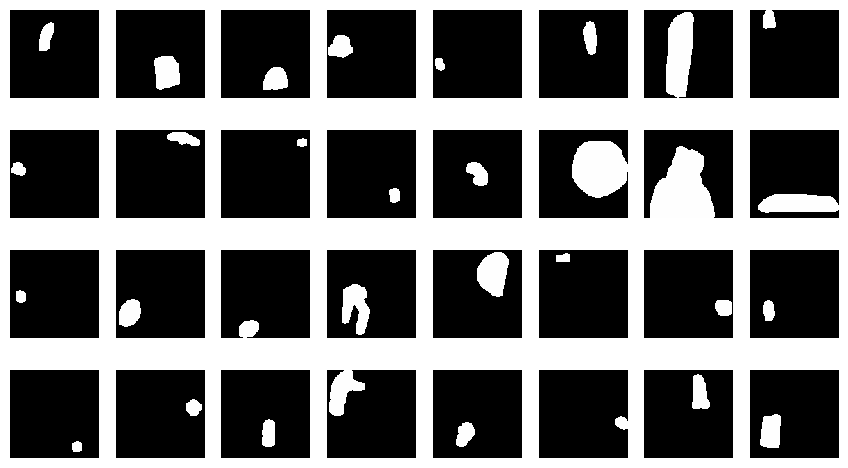

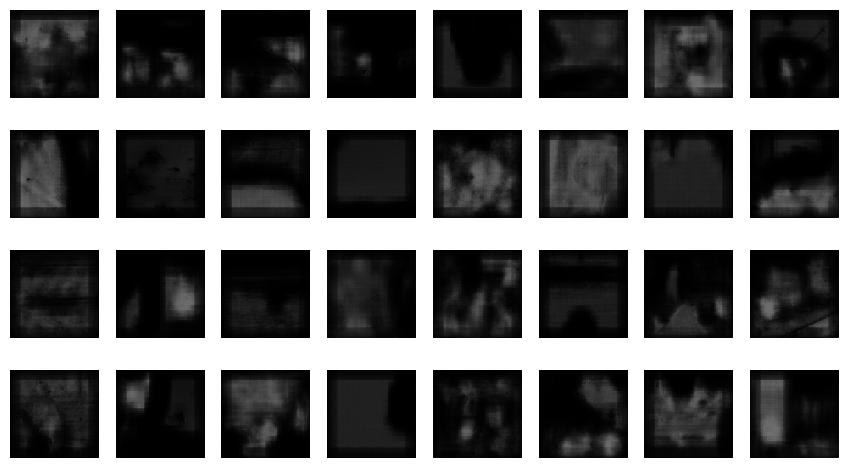

In [10]:
import torch
from mylib.data_io import show_images


model = model.to(DEVICE)
model.eval()

# テストデータセットで精度を評価
sum_recall = 0
sum_precision = 0
sum_IoU = 0
with torch.inference_mode():
    for X, Y in tqdm(test_dataloader):
        X = X.to(DEVICE) # 入力画像
        Y = Y.to(DEVICE) # 正解のマスク画像
        with torch.amp.autocast_mode.autocast(enabled=USE_AMP, device_type='cuda', dtype=FLOAT_DTYPE):
            Y_pred = model(X)
        recall, precision, IoU = region_consistency_metric(Y_pred.to(torch.float32), Y)
        sum_recall += recall * len(X)
        sum_precision += precision * len(X)
        sum_IoU += IoU * len(X)
avg_recall = sum_recall / test_size
avg_precision = sum_precision / test_size
avg_IoU = sum_IoU / test_size
print('recall = {0:.6f}'.format(avg_recall))
print('precision = {0:.6f}'.format(avg_precision))
print('IoU = {0:.6f}'.format(avg_IoU))
print('')

# 推定結果の例を表示
show_images(Y.to('cpu').detach(), num=32, num_per_row=8, title='ground truth', save_fig=False, save_dir=MODEL_DIR)
show_images(Y_pred.to('cpu').detach(), num=32, num_per_row=8, title='estimated', save_fig=False, save_dir=MODEL_DIR)